In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import tensorflow as tf
import math
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import sample
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from  tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from utils import plot_metrics
from utils import F1Score
from utils import plot_accuracy

In [2]:
# To Activate GPU if there is
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-09-19 19:14:01.662377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-19 19:14:01.697650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-19 19:14:01.698158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
data_directory = 'dataset'

train_img = pd.read_csv(os.path.join(data_directory, 'MURA-v1.1/train_image_paths.csv'), names=['path'])
test_img = pd.read_csv(os.path.join(data_directory, 'MURA-v1.1/test_image_paths.csv'), names=['path'])

train_img

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [4]:
orig_len = len(train_img)

# Split the train into training and validation dataset
valid_img= train_img.sample(frac=0.2, random_state=1337)

# Remove the selected image paths for the validation in training img paths
train_img = train_img.drop(valid_img.index)

valid_length = len(valid_img)
train_length = len(train_img)

print('Original Size of Train: ', orig_len)
print('Validation dataset size: ', valid_length)
print('Train dataset size: ', train_length)

assert(orig_len == (valid_length + train_length))

Original Size of Train:  36808
Validation dataset size:  7362
Train dataset size:  29446


In [5]:
train_img

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36802,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [6]:
# Add labels to the paths
train_img['label'] = train_img['path'].map(lambda x: '1' if 'positive' in x else '0')
valid_img['label'] = valid_img['path'].map(lambda x: '1' if 'positive' in x else '0')
test_img['label'] = test_img['path'].map(lambda x: '1' if 'positive' in x else '0')

train_class_frequency = pd.DataFrame(train_img['label'].value_counts())
valid_class_frequency = pd.DataFrame(valid_img['label'].value_counts())
test_class_frequency = pd.DataFrame(test_img['label'].value_counts())

print('Train Data Class Distribution: \n',train_class_frequency)
print('Validation Data Class Distribution: \n',valid_class_frequency)
print('Test Data Class Disribution: \n', test_class_frequency)

Train Data Class Distribution: 
    label
0  17483
1  11963
Validation Data Class Distribution: 
    label
0   4452
1   2910
Test Data Class Disribution: 
    label
0   1667
1   1530


In [7]:
img_height = img_width = 300

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img.astype(np.uint8))

def resize_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return cv2.resize(img, (img_height, img_width))

def canny_cropping(img):
    convert_img = np.array(img, dtype=np.uint8)

    gray = cv2.cvtColor(convert_img, cv2.COLOR_RGB2GRAY)


    ave_brightness = math.floor(np.average(gray))
    min_pixel = min(gray.flatten())

    edges = cv2.Canny(gray, min_pixel, ave_brightness)
    cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x, y, w, h = cv2.boundingRect(edges)
        gray = gray[y:y+h, x:x+w]
        break

    return gray


def preprocessing_with_clahe(img):
    cropped = canny_cropping(img)
    clahe = apply_clahe(cropped)
    return resize_img(clahe)


In [8]:
data_path = 'dataset/'
batch = 8
train_batches = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    preprocessing_function=preprocessing_with_clahe
).flow_from_dataframe(
    target_size=(img_height, img_width),
    dataframe=train_img, 
    directory= data_path,
    class_mode='binary',
    x_col='path',
    y_col='label',
    batch_size=batch)

valid_batches = ImageDataGenerator(
    preprocessing_function=preprocessing_with_clahe
).flow_from_dataframe(
    target_size=(img_height, img_width),
    dataframe= valid_img,
    directory= data_path,
    class_mode='binary',
    x_col='path',
    y_col='label',
    shuffle=False,
    batch_size=batch)

test_batches = ImageDataGenerator(
    preprocessing_function=preprocessing_with_clahe
).flow_from_dataframe(
    target_size=(img_height, img_width),
    dataframe=test_img, 
    directory= data_path,
    class_mode='binary',
    x_col='path',
    y_col='label',
    batch_size=batch, 
    shuffle=False)

Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [9]:
# Load the pretrained base model of EfficientNetV2
feature_extractor = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    classes=2,
)

2022-09-19 19:14:03.136400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 19:14:03.139458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-19 19:14:03.140023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-19 19:14:03.140579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [10]:
# Freeze the convulutional base
feature_extractor.trainable = False

In [11]:
METRICS = [ 
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
    F1Score(name="f1_score"),
]

In [12]:
def build_model():
    
    image_batch, label_batch = next(iter(train_batches))
    feature_batch = feature_extractor(image_batch)

    # Create GlobalAveragePooling Layer
    global_ave_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_ave = global_ave_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    prediction_batch = prediction_layer(feature_batch_ave)

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = feature_extractor(inputs, training=False)
    x = global_ave_layer(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model_with_clahe = Model(inputs, outputs)

    model_with_clahe.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

    return model_with_clahe


In [13]:
model_with_clahe = build_model()

2022-09-19 19:14:10.581691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-19 19:14:11.823247: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-19 19:14:12.087629: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
model_with_clahe.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                             

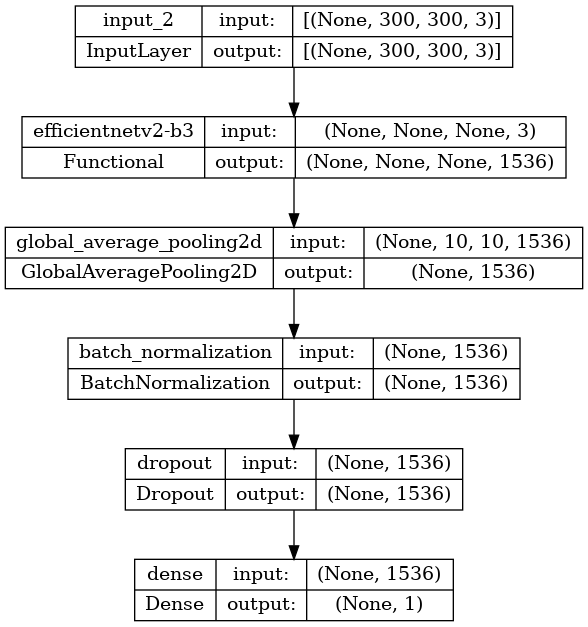

In [15]:
tf.keras.utils.plot_model(
    model_with_clahe,
    to_file=f"images/efficientNet_with_clahe_diagram.png",
    show_shapes=True,
    show_layer_names=True,
)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
    baseline=0.0,
    restore_best_weights=True,
)

base_model_name = feature_extractor.name
model_path = f'models/with_clahe/{base_model_name}_feature_extractor.h5'

checkpoint_feature = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_cohen_kappa',
    mode='max',
    save_best_only = True,
)

feature_training = f'training_records/with_clahe/{base_model_name}_feature_extraction.csv'
logs = tf.keras.callbacks.CSVLogger(filename=feature_training, separator=',')

In [17]:
if os.path.isfile(model_path) is False:
    history = model_with_clahe.fit(
        train_batches, 
        validation_data=valid_batches, 
        epochs=25, 
        verbose=2,
        callbacks=[early_stopping, checkpoint_feature, logs],
    )

Epoch 1/25
3681/3681 - 618s - loss: 0.6732 - binary_accuracy: 0.6416 - precision: 0.5672 - recall: 0.4977 - cohen_kappa: 0.2425 - f1_score: 0.5302 - val_loss: 0.5724 - val_binary_accuracy: 0.7157 - val_precision: 0.6435 - val_recall: 0.6296 - val_cohen_kappa: 0.4031 - val_f1_score: 0.6364 - 618s/epoch - 168ms/step
Epoch 2/25
3681/3681 - 595s - loss: 0.6056 - binary_accuracy: 0.6877 - precision: 0.6371 - recall: 0.5373 - cohen_kappa: 0.3362 - f1_score: 0.5830 - val_loss: 0.5503 - val_binary_accuracy: 0.7260 - val_precision: 0.6600 - val_recall: 0.6330 - val_cohen_kappa: 0.4228 - val_f1_score: 0.6462 - 595s/epoch - 162ms/step
Epoch 3/25
3681/3681 - 570s - loss: 0.5854 - binary_accuracy: 0.7022 - precision: 0.6593 - recall: 0.5523 - cohen_kappa: 0.3664 - f1_score: 0.6011 - val_loss: 0.5407 - val_binary_accuracy: 0.7361 - val_precision: 0.6624 - val_recall: 0.6777 - val_cohen_kappa: 0.4501 - val_f1_score: 0.6700 - 570s/epoch - 155ms/step
Epoch 4/25
3681/3681 - 558s - loss: 0.5693 - binary_

In [18]:
if os.path.isfile(model_path) is False:
    print('Model Saved')
    model_with_clahe.save(model_path)


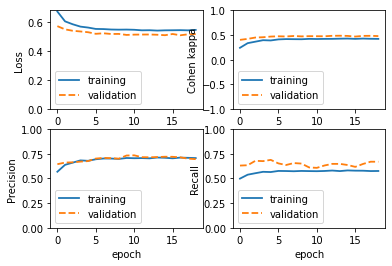

In [19]:
plot_metrics(history)

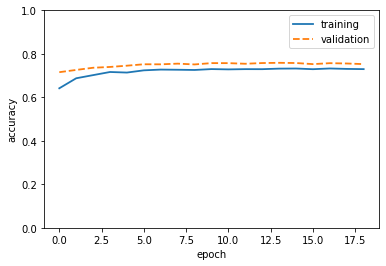

In [20]:
plot_accuracy(history)

In [21]:
## Finetuning
trained_model = tf.keras.models.load_model(
    model_path,
    custom_objects={'F1Score': F1Score}
)

In [22]:
print("number of layers in the base model: ", len(feature_extractor.layers))

number of layers in the base model:  409


In [23]:
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                             

In [24]:
def unfreeze_model(model):
    base_model = model.layers[1]
    base_model.trainable = True
    # print(len(base_model.layers))
    # for layer in base_model.layers[:-20]:
    #     layer.trainable = True
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )


In [25]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=4,
    mode="max",
    factor=0.2,
    min_lr=1e-10,
)

base_model_name = feature_extractor.name
finetune_path = f'models/with_clahe/{base_model_name}_finetuned.h5'

finetuning_checkpoint  = tf.keras.callbacks.ModelCheckpoint(
    filepath=finetune_path,
    monitor='val_cohen_kappa',
    mode='max',
    save_best_only = True,
)

finetuning = f'training_records/with_clahe/{base_model_name}_finetuning.csv'
fine_logs = tf.keras.callbacks.CSVLogger(filename=finetuning, separator=',')


In [26]:
unfreeze_model(trained_model)

In [27]:
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                             

In [28]:
finetune_history = trained_model.fit(
    train_batches,
    epochs=25,
    validation_data=valid_batches,
    callbacks=[early_stopping, reduce_lr_on_plateau, finetuning_checkpoint, fine_logs],
)

Epoch 1/25
3681/3681 [==============================] - 643s 170ms/step - loss: 0.5180 - binary_accuracy: 0.7538 - precision: 0.7209 - recall: 0.6376 - cohen_kappa: 0.4792 - f1_score: 0.6767 - val_loss: 0.4631 - val_binary_accuracy: 0.7922 - val_precision: 0.7916 - val_recall: 0.6436 - val_cohen_kappa: 0.5507 - val_f1_score: 0.7100 - lr: 1.0000e-05
Epoch 2/25
3681/3681 [==============================] - 687s 187ms/step - loss: 0.4800 - binary_accuracy: 0.7799 - precision: 0.7640 - recall: 0.6631 - cohen_kappa: 0.5341 - f1_score: 0.7100 - val_loss: 0.4404 - val_binary_accuracy: 0.8108 - val_precision: 0.8302 - val_recall: 0.6553 - val_cohen_kappa: 0.5892 - val_f1_score: 0.7325 - lr: 1.0000e-05
Epoch 3/25
3681/3681 [==============================] - 678s 184ms/step - loss: 0.4510 - binary_accuracy: 0.7973 - precision: 0.7833 - recall: 0.6928 - cohen_kappa: 0.5721 - f1_score: 0.7353 - val_loss: 0.4590 - val_binary_accuracy: 0.7935 - val_precision: 0.7311 - val_recall: 0.7557 - val_cohen_k

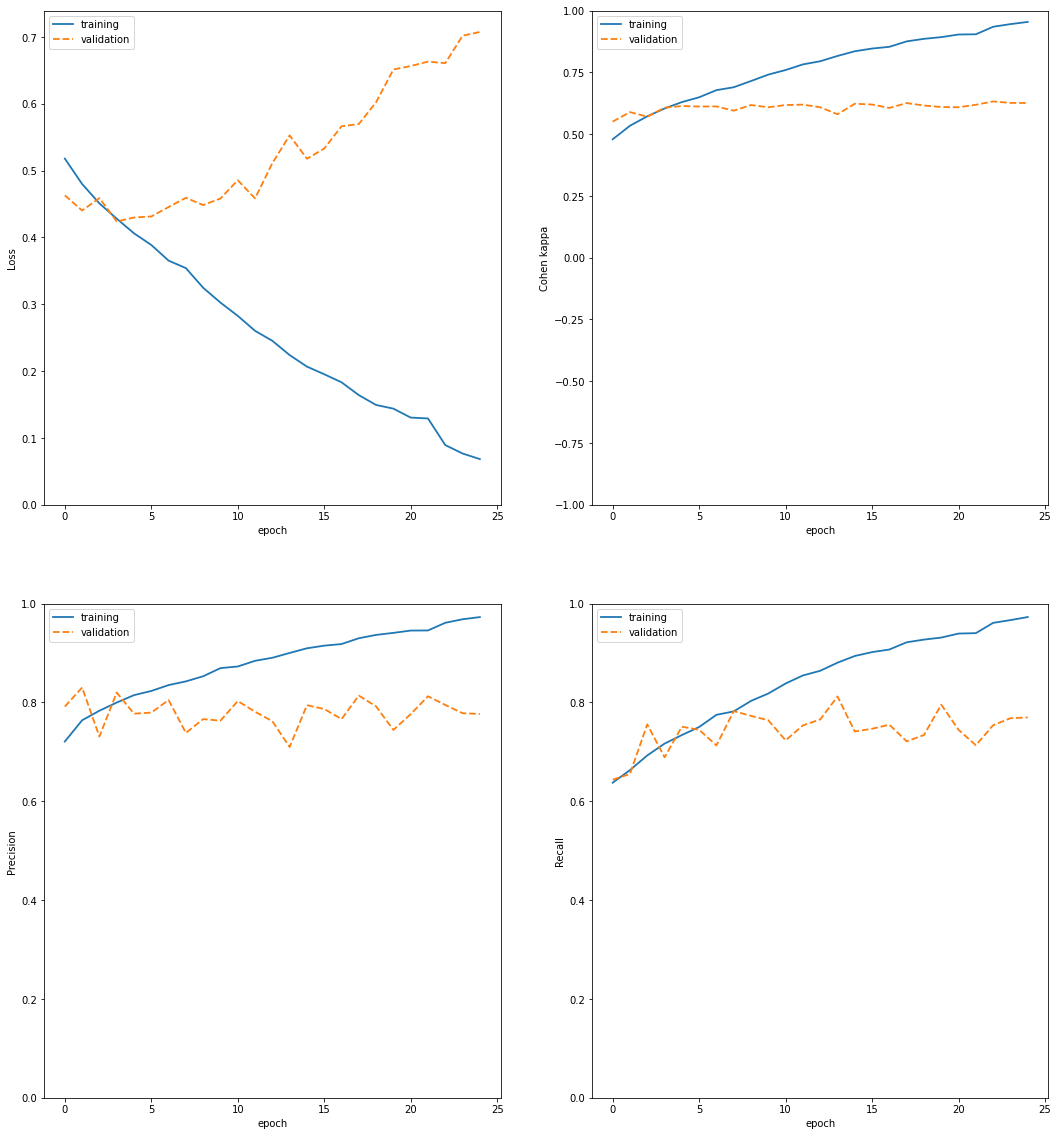

In [29]:
plot_metrics(finetune_history)


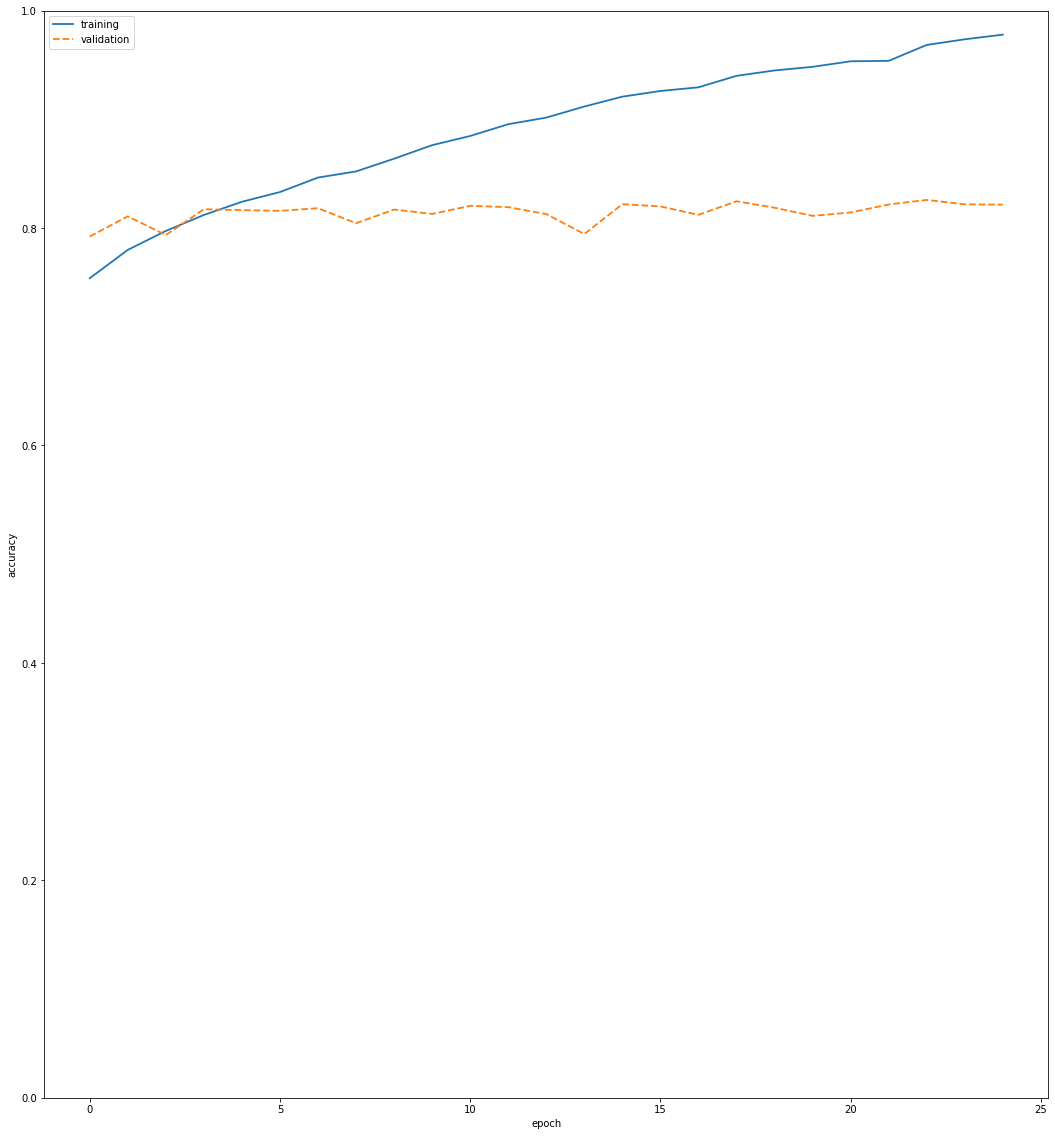

In [30]:
plot_accuracy(finetune_history)

In [31]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = trained_model.evaluate(valid_batches, verbose=1)

921/921 [==============================] - 58s 63ms/step - loss: 0.7076 - binary_accuracy: 0.8215 - precision: 0.7767 - recall: 0.7698 - cohen_kappa: 0.6261 - f1_score: 0.7732


In [32]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.7075612545013428
binary_accuracy: 0.8215159177780151
precision   : 0.7766990065574646
recall      : 0.769759476184845
cohen_kappa : 0.6260740756988525
f1_score    : 0.7732136845588684


In [33]:
if os.path.isfile(finetune_path) is False:
    print('Model Saved')
    trained_model.save(finetune_path)